In [1]:
#import the necessary modules 
%matplotlib inline 
import numpy as np 
import matplotlib.pylab as plt 
import pandas as pd 
import scipy
import sklearn
import itertools as it
from itertools import cycle 
import os.path as op
import timeit 
import json
from matplotlib import animation
import matplotlib.font_manager as font_manager

# These imports are for creating the percent occupancy heat map 
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

In [2]:
import multiprocessing as m_proc
m_proc.cpu_count()

4

Import MDAnalysis

In [3]:
# Import MDAnalysis
import MDAnalysis as mda
import MDAnalysis.analysis.distances as maa_dist

In [4]:
#Units of Angstroms 
dmax = 4.0 

In [5]:
## Define a function that does this, Courtesy of MDAnalysis tutorial 
def get_protresd_list(prot_atoms, g2_atoms, dmax, universe):
    """Find all protein residues for which atoms that are within dmax"""
    ro = len(prot_atoms)
    cl = len(g2_atoms)
    dij_tri = np.zeros(shape=(ro,cl))
    dij_tri = maa_dist.distance_array(prot_atoms.positions, g2_atoms.positions, box=universe.trajectory.ts.dimensions)
    exp_prot_atoms = np.any(dij_tri <= dmax, axis=1)
    mk = np.array(prot_atoms[exp_prot_atoms].residues)
    return mk


# Define a function that outputs a dictionary of AA protein number and frame counts, where 
# the inputs will be number of frames, universe, prot and group 2 atom group, and dmax 
# Write function that takes a no of total frames, protein atom positions and group 2 atoms positions 
# and gives a dictionary of protein AA as keys and frame count as values 

def aa_frmcount(prot_atoms, g2_atoms, dmax, universe, start, end):
    """This function will output a dictionary of AA protein number and its corresponding frame count and occupancy"""
    
    aa_dict = {}
    laa = np.zeros(shape=len(prot_atoms.residues))
    br = np.zeros(shape=(len(prot_atoms.residues),2), dtype=object)
    pr_rest = np.array(prot_atoms.residues)
    
    for ts in universe.trajectory[start:end]: 
        count = 0
        bsres = get_protresd_list(prot_atoms, g2_atoms, dmax, universe)
        
        if bsres.size == 0: 
            pass
        elif bsres.size != 0: 
            count += 1
            for i in bsres.flat:
                res_ind = np.where(pr_rest == i)[0]
                laa[res_ind[0]] = laa[res_ind[0]] + count 
                
    fin_res = np.where(laa != 0)[0]
    
    # Calculate occupancy for each residue 
    for i in fin_res.flat:
        br[i][1] = [laa[i], laa[i]/(end - start)]
        
    return br 

In [6]:
def AA_list_org(lorg_list):
    
    """List elements need have 'GLY  XX' as string format, where XX reps the number of GLY residues. Output is a
    sorted list of 'AA XX' according to the below order.  """
    
    hydrophobic_res = ['ALA', 'ILE', 'LEU', 'VAL', 'GLY', 'PRO','PHE', 'TRP','MET']
    polar_res = ['ASN', 'CYS', 'GLN', 'SER', 'THR','TYR']
    neg_res = ['ASP', 'GLU']
    pos_res = ['ARG', 'HIS', 'LYS']
    
    all_res = [pos_res, neg_res, polar_res, hydrophobic_res]
    #Change order of residues before making the bar graph
    # (1) Positively charged
    # (2) Negatively charged
    # (3) Polar residues 
    # (4) Hydrophobic residues 
    
    # This chunk of code sorts the counts of each AA that have 1001 or 1002 frame count based 
    # on the AA order in all_res
    arr_list = []

    for row in all_res:
        for i in range(len(lorg_list)):
            for j in range(len(row)):
                if row[j] == lorg_list[i][0:3]:
                    arr_list.append(lorg_list[i])
                    
    #This chunk of code splits the list arr_list to makes the AA: count of 1001 or 1002 frames data plottable 
    f_list = []
    fn_list = []
    for i in range(len(arr_list)):
        f_list.append(arr_list[i][0:3])
        fn_list.append(int(arr_list[i][5:]))
        
    return f_list, fn_list

## Tetramer Catalase in pure water 1 ns simulation: Calc. of surface residues

#### Distance-based analysis 

Find residues that have at least one atom within a cutoff $d = 4.0$ Angstrom near water molecules in Catalase/water simulation

Calculate the number of surface catalase residues from a 1 ns Catalase/water simulation

In [7]:
# Load universe of the BSA/water simulation
cat_wat = mda.Universe("tout_loacl/traj.pdb", "traj_comp.xtc")

In [8]:
# Check Universe 
cat_wat

<Universe with 243538 atoms>

In [9]:
# Check Trajectory Length 
cattrj = len(cat_wat.trajectory)

In [10]:
cattrj

101

In [11]:
# Load protein atoms, heavy atoms only 
wcat_prot = cat_wat.select_atoms("protein and not type H")

In [12]:
wcat_prot.positions.shape

(16072, 3)

In [13]:
len(cat_wat.select_atoms("protein and segid D").residues)

499

In [14]:
cat_wat.select_atoms("resname SOL")

<AtomGroup with 212070 atoms>

Text(0.5, 1.05, 'Catalase Atomic Contact Map: PDB code 1TGU')

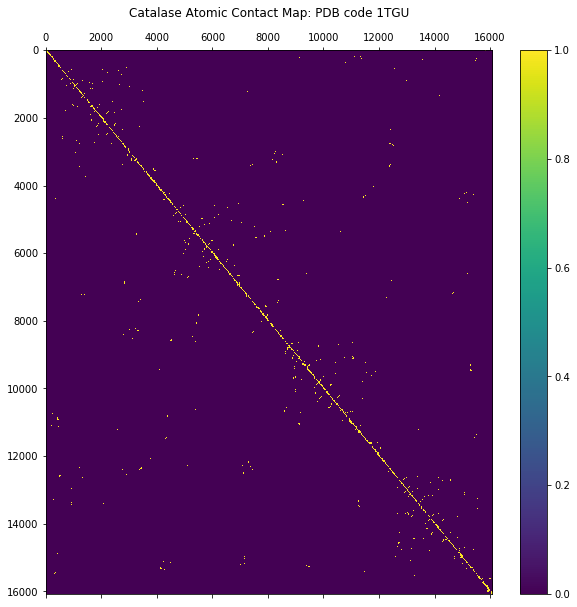

In [15]:
#Length units in MD Analysis is Angstroms, Using 8.5 A cutoff to better visualize atomic contacts
bs = maa_dist.contact_matrix(wcat_prot.positions,cutoff=7.5,box=cat_wat.dimensions)
fig, ax = plt.subplots(figsize=(10,10))
l_s = ax.matshow(bs.astype(int), aspect="auto")
fig.colorbar(l_s, ax=ax)
ax.set_title('Catalase Atomic Contact Map: PDB code 1TGU')

In [16]:
pr_res = list(wcat_prot.residues)
ss_res = [str(row) for row in pr_res]
cat_resdat = pd.DataFrame(data=ss_res, columns=['Catalase_des_res'])
cat_resdat.head()

,Catalase_des_res
0,"<Residue ASN, 3>"
1,"<Residue ARG, 4>"
2,"<Residue ASP, 5>"
3,"<Residue PRO, 6>"
4,"<Residue ALA, 7>"


In [17]:
cat_res1ns = json.load(open("MDA_Catalase_1ns.txt"))
#cat_res1ns

In [18]:
# One catalase residue (Residue #182) does not contact water within 4 Angstroms within 1 ns
# This code isolates frame counts and puts them in a pandas dataframe 
results = []
final_res = [] 
for item in cat_res1ns:
    results.append(item[1])

for i in results:
    if i == 0:
        final_res.append(i)
    elif i != 0:
        final_res.append(i[0])
#len(final_res)

In [19]:
cat_resdat['res_counts_1ns'] = final_res
cat_resdat.head()

,Catalase_des_res,res_counts_1ns
0,"<Residue ASN, 3>",101.0
1,"<Residue ARG, 4>",101.0
2,"<Residue ASP, 5>",101.0
3,"<Residue PRO, 6>",101.0
4,"<Residue ALA, 7>",101.0


In [20]:
# residue indexing for catalase 
len(range(3,501))

# VMD calc using protein within A A of water 
chainA_vmd = pd.read_csv("tout_loacl/occ_chainA.txt", sep=" ", header=None, usecols=None ,index_col=None)
chainB_vmd = pd.read_csv("tout_loacl/occ_chainB.txt", sep=" ", header=None, usecols=None ,index_col=None)
chainC_vmd = pd.read_csv("tout_loacl/occ_chainC.txt", sep=" ", header=None, usecols=None ,index_col=None)
chainD_vmd = pd.read_csv("tout_loacl/occ_chainD.txt", sep=" ", header=None, usecols=None ,index_col=None)

chA_res = list(chainA_vmd[1])
chB_res = list(chainB_vmd[1])
chC_res = list(chainC_vmd[1])
chD_res = list(chainD_vmd[1])

cat_vmd = chA_res + chB_res + chC_res + chD_res
cat_resdat['vmd_count_1ns'] = cat_vmd

In [21]:
cat_resdat.head()

,Catalase_des_res,res_counts_1ns,vmd_count_1ns
0,"<Residue ASN, 3>",101.0,0
1,"<Residue ARG, 4>",101.0,0
2,"<Residue ASP, 5>",101.0,102
3,"<Residue PRO, 6>",101.0,102
4,"<Residue ALA, 7>",101.0,102


In [22]:
# Sasa calc using VMD 
sasa_cha = pd.read_csv("sasa_pchA.txt", sep=" ", header=None, names=['res_label','res_no','sasa_label','sasa_chA'])
sasa_chb = pd.read_csv("sasa_pchB.txt", sep=" ", header=None)
sasa_chc = pd.read_csv("sasa_pchC.txt", sep=" ", header=None)
sasa_chd = pd.read_csv("sasa_pchD.txt", sep=" ", header=None)
#sasa_cha

In [23]:
sasa_cha['sasa_chB'] = sasa_chb[3]
sasa_cha['sasa_chC'] = sasa_chc[3]
sasa_cha['sasa_chD'] = sasa_chd[3]
sasa_cha.head()

,res_label,res_no,sasa_label,sasa_chA,sasa_chB,sasa_chC,sasa_chD
0,residue:,"10,",sasa:,96.610344,98.045898,103.471283,86.202293
1,residue:,"100,",sasa:,84.855194,74.129868,81.029602,96.959503
2,residue:,"101,",sasa:,82.435638,111.213448,119.146339,106.811005
3,residue:,"102,",sasa:,93.312248,89.455994,96.232155,101.974808
4,residue:,"103,",sasa:,33.944782,47.592072,34.958199,37.598480


In [24]:
num_lis = []
for index, row in sasa_cha.iterrows():
    if str(',') in row['res_no']:
        gh = int(row['res_no'][:-1])
        num_lis.append(gh)
sasa_cha['res_no'] = num_lis
sasa_cha.head()

,res_label,res_no,sasa_label,sasa_chA,sasa_chB,sasa_chC,sasa_chD
0,residue:,10,sasa:,96.610344,98.045898,103.471283,86.202293
1,residue:,100,sasa:,84.855194,74.129868,81.029602,96.959503
2,residue:,101,sasa:,82.435638,111.213448,119.146339,106.811005
3,residue:,102,sasa:,93.312248,89.455994,96.232155,101.974808
4,residue:,103,sasa:,33.944782,47.592072,34.958199,37.598480


In [25]:
org_index = sasa_cha.index
sasa_tot = sasa_cha.sort_values('res_no')
sasa_tot.index = org_index
sasa_tot.head()

,res_label,res_no,sasa_label,sasa_chA,sasa_chB,sasa_chC,sasa_chD
0,residue:,3,sasa:,173.243301,182.243988,174.538239,177.693893
1,residue:,4,sasa:,150.692017,133.533661,149.504303,145.796326
2,residue:,5,sasa:,48.981670,31.080713,51.481171,48.665924
3,residue:,6,sasa:,40.678082,38.809196,31.427261,40.209156
4,residue:,7,sasa:,31.938034,22.977932,31.155411,25.732910


In [26]:
sasa_tot['res_no'] = cat_resdat['Catalase_des_res']
sasa_tot.drop('res_label', axis=1, inplace=True)
sasa_tot.head()

,res_no,sasa_label,sasa_chA,sasa_chB,sasa_chC,sasa_chD
0,"<Residue ASN, 3>",sasa:,173.243301,182.243988,174.538239,177.693893
1,"<Residue ARG, 4>",sasa:,150.692017,133.533661,149.504303,145.796326
2,"<Residue ASP, 5>",sasa:,48.981670,31.080713,51.481171,48.665924
3,"<Residue PRO, 6>",sasa:,40.678082,38.809196,31.427261,40.209156
4,"<Residue ALA, 7>",sasa:,31.938034,22.977932,31.155411,25.732910


In [27]:
a_a = ["GLY","ALA","VAL","LEU","ILE","MET","PHE","TRP","PRO","SER","THR","CYS","TYR","ASN","GLN","ASP"
               ,"GLU","LYS","ARG","HIS"]

In [28]:
#From VMD, SASA calculation on each residue, surface exposed is area greater than 1 angstrom squared
ss_list = []
jl = ['A', 'B', 'C','D']

for i in range(len(a_a)):
    count = 0
    #print(a_a[i])
    for index, row in sasa_tot.iterrows():
        if a_a[i] in row["res_no"]:
            #print(row['res_no'])
            for j in range(len(jl)):
                if row['sasa_ch'+str(jl[j])] > 1.0: 
                    count += 1
                    #print(row['res_no'], row['sasa_ch'+str(jl[j])])
                    #print(sasa_tot.iloc[index])
                    
    ss_list.append(str(str(a_a[i])+"  "+str(count)))
#ss_list

In [29]:
sasa_tot.iloc[0]

res_no        <Residue ASN, 3>
sasa_label               sasa:
sasa_chA               173.243
sasa_chB               182.244
sasa_chC               174.538
sasa_chD               177.694
Name: 0, dtype: object

In [30]:
# Number of residues that do not contact water within 4 Angstroms (130 residues), Calc'd from MD Analysis
count = 0
for index, row in cat_resdat.iterrows():
    if row['res_counts_1ns'] != 101.0 and row['res_counts_1ns'] != 100.0:
        #print(row['res_counts_1ns'])
        count += 1
print(count)        

130


In [31]:
# Number of residues that do not contact water within 4 Angstroms (130 residues), Calc'd from VMD
count = 0
for index, row in cat_resdat.iterrows():
    if row['vmd_count_1ns'] != 102.0 and row['vmd_count_1ns'] != 101.0:
        #print(row['vmd_count_1ns'])
        count += 1
print(count) 

146


In [32]:
a_a = ["GLY","ALA","VAL","LEU","ILE","MET","PHE","TRP","PRO","SER","THR","CYS","TYR","ASN","GLN","ASP"
               ,"GLU","LYS","ARG","HIS"]

In [33]:
# From MD Analysis
#Get the count of bsa residues that have 1001 or 1002 frames ( I ran a 1 ns NPT simulation of 1 BSA in water )

#aa_count = pd.DataFrame(data=a_a)
c_list = []

for i in range(len(a_a)):
    count = 0
    for index, row in cat_resdat.iterrows():
        if a_a[i] in row["Catalase_des_res"]:
            if row['res_counts_1ns'] == 100.0: 
                #print(row['res_counts_1ns'])
                count += 1
                #c_list.append(str(str(a_a[i])+"  "+str(row['No. of frames']))) 
            elif row['res_counts_1ns'] == 101.0:
                #print(row['res_counts_1ns'])
                count += 1
                #c_list.append(str(str(a_a[i])+"  "+str(row['No. of frames'])))
    c_list.append(str(str(a_a[i])+"  "+str(count)))
    
#c_list

In [34]:
# From VMD
#Get the count of bsa residues that have 101 or 102 frames ( I ran a 1 ns NPT simulation of 1 catalase in water )

#aa_count = pd.DataFrame(data=a_a)
vmd_list = []

for i in range(len(a_a)):
    count = 0
    for index, row in cat_resdat.iterrows():
        if a_a[i] in row["Catalase_des_res"]:
            if row["vmd_count_1ns"] == 101.0: 
                count += 1
                #c_list.append(str(str(a_a[i])+"  "+str(row['No. of frames']))) 
            elif row["vmd_count_1ns"] == 102.0:
                count += 1
                #c_list.append(str(str(a_a[i])+"  "+str(row['No. of frames'])))
    vmd_list.append(str(str(a_a[i])+"  "+str(count)))

In [35]:
vmd_list

['GLY  125',
 'ALA  132',
 'VAL  124',
 'LEU  123',
 'ILE  70',
 'MET  40',
 'PHE  111',
 'TRP  20',
 'PRO  141',
 'SER  89',
 'THR  79',
 'CYS  16',
 'TYR  80',
 'ASN  108',
 'GLN  80',
 'ASP  144',
 'GLU  95',
 'LYS  89',
 'ARG  107',
 'HIS  77']

In [36]:
c_list

['GLY  123',
 'ALA  122',
 'VAL  119',
 'LEU  120',
 'ILE  54',
 'MET  38',
 'PHE  110',
 'TRP  20',
 'PRO  143',
 'SER  96',
 'THR  86',
 'CYS  12',
 'TYR  73',
 'ASN  116',
 'GLN  81',
 'ASP  149',
 'GLU  96',
 'LYS  100',
 'ARG  124',
 'HIS  84']

In [37]:
ss_list

['GLY  122',
 'ALA  122',
 'VAL  127',
 'LEU  129',
 'ILE  59',
 'MET  36',
 'PHE  115',
 'TRP  22',
 'PRO  145',
 'SER  99',
 'THR  83',
 'CYS  11',
 'TYR  73',
 'ASN  115',
 'GLN  84',
 'ASP  151',
 'GLU  96',
 'LYS  100',
 'ARG  124',
 'HIS  84']

In [38]:
#hydrophobic_res = ['ALA', 'ILE', 'LEU', 'VAL', 'GLY', 'PRO','PHE', 'TRP','MET']
#polar_res = ['ASN', 'CYS', 'GLN', 'SER', 'THR','TYR']
#neg_res = ['ASP', 'GLU']
#pos_res = ['ARG', 'HIS', 'LYS']
# aromatic_res = ['PHE', 'TRP', 'TYR', 'HIS']
#all_res = [pos_res, neg_res, polar_res, hydrophobic_res]

# Put the AA count in a pandas dataframe 
dg , ji = AA_list_org(c_list)
aa_count = pd.DataFrame(data=dg, index=None, columns=['Amino_acids'])
new_lf = pd.Series(data=ji, index=None)
vmg, vmdj = AA_list_org(vmd_list)
n2lf = pd.Series(data=vmdj, index=None)
sk, sl = AA_list_org(ss_list)
sa_tt = pd.Series(data=sl, index=None)
aa_count['No_of_surf_res (MDAnalysis)'] = new_lf
aa_count['No_of_surf_res (VMD_prot_wat)'] = n2lf
aa_count['No_of_surf_res (VMD_sasa)'] = sa_tt
aa_count

,Amino_acids,No_of_surf_res (MDAnalysis),No_of_surf_res (VMD_prot_wat),No_of_surf_res (VMD_sasa)
0,LYS,100,89,100
1,ARG,124,107,124
2,HIS,84,77,84
3,ASP,149,144,151
4,GLU,96,95,96
5,SER,96,89,99
6,THR,86,79,83
7,CYS,12,16,11
8,TYR,73,80,73
9,ASN,116,108,115


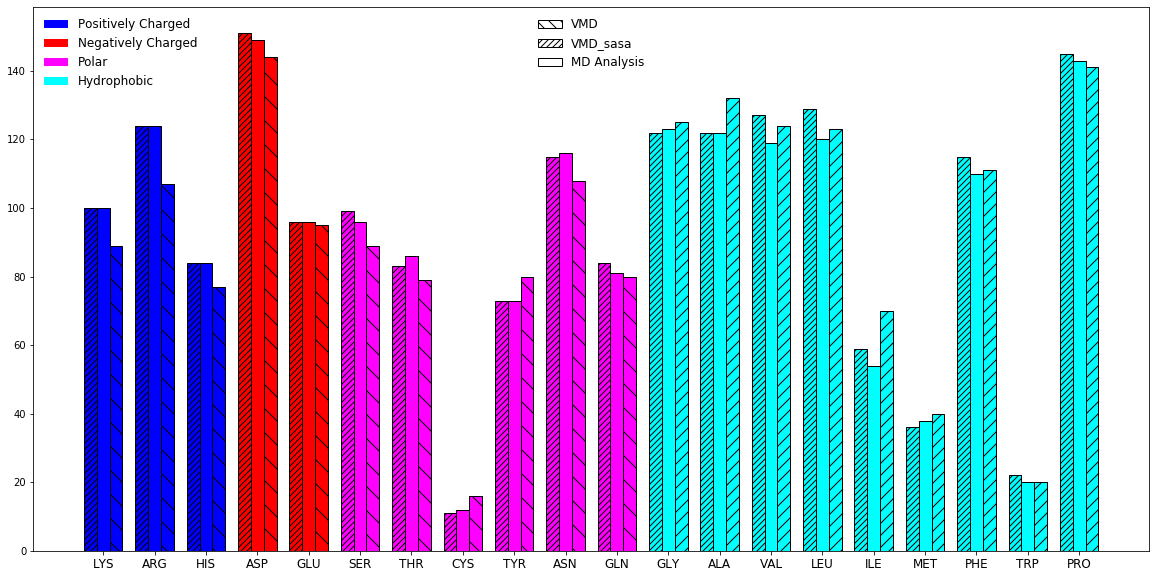

In [39]:
import matplotlib.patches as mpatches

circ1= mpatches.Patch(facecolor='None',edgecolor='black', hatch=r'\\',label='VMD')
circ2= mpatches.Patch(facecolor='None',edgecolor='black', hatch=r'////',label='VMD_sasa')
circ3= mpatches.Patch(facecolor='None', edgecolor='black',label='MD Analysis')
circ4= mpatches.Patch(facecolor='blue',label='Positively Charged')
circ5= mpatches.Patch(facecolor='red',label='Negatively Charged')
circ6= mpatches.Patch(facecolor='magenta',label='Polar')
circ7= mpatches.Patch(facecolor='cyan',label='Hydrophobic')

#plotting 
#Change order of residues before making the bar graph
# (!) Positively charged
# (2) Negatively charged
# (3) Polar residues 
# (4) Hydrophobic residues 
x = np.arange(20)
width = 0.25
#leg_1 = ['MD Analysis', 'VMD Calculation']
leg = ['Positively Charged', 'Negatively Charged', 'Polar', 'Hydrophobic']
plt.figure(figsize=(20,10))
plt.bar(x[0:3], aa_count['No_of_surf_res (MDAnalysis)'][0:3], width, color='blue', edgecolor='black')
plt.bar(x[0:3]+(width), aa_count['No_of_surf_res (VMD_prot_wat)'][0:3], width, color='blue', hatch='\\', edgecolor='black')
plt.bar(x[0:3]-(width), aa_count['No_of_surf_res (VMD_sasa)'][0:3], width, color='blue', hatch=r'////', edgecolor='black')

plt.bar(x[3:5], aa_count['No_of_surf_res (MDAnalysis)'][3:5], width, color='red', edgecolor='black')
plt.bar(x[3:5]+(width), aa_count['No_of_surf_res (VMD_prot_wat)'][3:5], width, color='red', hatch='\\', edgecolor='black')
plt.bar(x[3:5]-(width), aa_count['No_of_surf_res (VMD_sasa)'][3:5], width, color='red', hatch=r'////', edgecolor='black')

plt.bar(x[5:11], aa_count['No_of_surf_res (MDAnalysis)'][5:11], width, color='magenta', edgecolor='black')
plt.bar(x[5:11]+(width), aa_count['No_of_surf_res (VMD_prot_wat)'][5:11], width, color='magenta', hatch='\\'
        , edgecolor='black')
plt.bar(x[5:11]-(width), aa_count['No_of_surf_res (VMD_sasa)'][5:11], width, color='magenta', hatch=r'////', edgecolor='black')

plt.bar(x[11:20], aa_count['No_of_surf_res (MDAnalysis)'][11:20], width, color='cyan', edgecolor='black')
plt.bar(x[11:20]+(width), aa_count['No_of_surf_res (VMD_prot_wat)'][11:20], width, color='cyan'
        , hatch='//', edgecolor='black')
plt.bar(x[11:20]-(width), aa_count['No_of_surf_res (VMD_sasa)'][11:20], width, hatch=r'////',color='cyan', edgecolor='black')
plt.xticks(x,aa_count['Amino_acids'], fontsize=12)
legend1 = plt.legend(handles = [circ4, circ5, circ6, circ7], loc=0,fontsize=12, frameon=False)
plt.legend(handles = [circ1, circ2, circ3],loc=9,fontsize=12, frameon=False)
plt.gca().add_artist(legend1)

# need to check residue indexing in my code

### Calculated from MD Analysis, protein within 4 Angstroms of water

In [40]:
# Number of positively charged residues (MD analysis)
aa_count['No_of_surf_res (MDAnalysis)'][0:3].sum()

308

In [41]:
# Number of negatively charged residues (MD Analysis)
aa_count['No_of_surf_res (MDAnalysis)'][3:5].sum()

245

In [42]:
# Number of polar residues (MD Analysis)
aa_count['No_of_surf_res (MDAnalysis)'][5:11].sum()

464

In [43]:
# Number of hydrophobic residues (MD Analysis)
aa_count['No_of_surf_res (MDAnalysis)'][11:20].sum()

849

In [44]:
# aromatic_res = ['PHE', 'TRP', 'TYR', 'HIS']
hf = aa_count['No_of_surf_res (MDAnalysis)'][8].sum() 
hf_1 = aa_count['No_of_surf_res (MDAnalysis)'][17:19].sum() 
hf_2 = aa_count['No_of_surf_res (MDAnalysis)'][2].sum()
hf +hf_1 +hf_2

287

In [45]:
aa_count['No_of_surf_res (MDAnalysis)'][17:19].sum()

130

### Calculated from VMD, protein within 4 Angstroms of water

In [46]:
# Number of positively charged residues (VMD Protein water)
aa_count['No_of_surf_res (VMD_prot_wat)'][0:3].sum()

273

In [47]:
# Number of negatively charged residues (VMD)
aa_count['No_of_surf_res (VMD_prot_wat)'][3:5].sum()

239

In [48]:
# Number of polar residues (VMD)
aa_count['No_of_surf_res (VMD_prot_wat)'][5:11].sum()

452

In [49]:
# Number of hydrophobic residues (VMD)
aa_count['No_of_surf_res (VMD_prot_wat)'][11:20].sum()

886

In [50]:
# aromatic_res = ['PHE', 'TRP', 'TYR', 'HIS']
hf_v = aa_count['No_of_surf_res (VMD_prot_wat)'][8].sum() 
hf_vmd = aa_count['No_of_surf_res (VMD_prot_wat)'][17:19].sum() 
hf_2v = aa_count['No_of_surf_res (VMD_prot_wat)'][2].sum()
hf_v +hf_vmd +hf_2v

288

### Calculated from VMD, Solvent accessible surface area greater than 1 angstrom squared

In [51]:
# Number of positively charged residues (MD analysis)
aa_count['No_of_surf_res (VMD_sasa)'][0:3].sum()

308

In [52]:
# Number of negatively charged residues (MD Analysis)
aa_count['No_of_surf_res (VMD_sasa)'][3:5].sum()

247

In [53]:
# Number of polar residues (MD Analysis)
aa_count['No_of_surf_res (VMD_sasa)'][5:11].sum()

465

In [54]:
# Number of hydrophobic residues (MD Analysis)
aa_count['No_of_surf_res (VMD_sasa)'][11:20].sum()

877

In [55]:
# aromatic_res = ['PHE', 'TRP', 'TYR', 'HIS']
ssf = aa_count['No_of_surf_res (VMD_sasa)'][8].sum() 
ssf_1 = aa_count['No_of_surf_res (VMD_sasa)'][17:19].sum() 
ssf_2 = aa_count['No_of_surf_res (VMD_sasa)'][2].sum()
ssf + ssf_1 + ssf_2

294

## BSA residue calculation using VMD SASA calculation 

In [61]:
# Sasa calc using VMD 
sasa_bsa = pd.read_csv("prot_BSA.txt", sep=" ", header=None, names=['res_label','res_no','sasa_label','sasa_BSA'])
sasa_bsa.head()

,res_label,res_no,sasa_label,sasa_BSA
0,residue:,1,sasa:,204.799179
1,residue:,10,sasa:,31.908531
2,residue:,100,sasa:,94.086922
3,residue:,101,sasa:,20.748587
4,residue:,102,sasa:,5.593543


In [62]:
org_ind = sasa_bsa.index
ss_tot = sasa_bsa.sort_values('res_no')
ss_tot.index = org_ind
ss_tot.head()

,res_label,res_no,sasa_label,sasa_BSA
0,residue:,1,sasa:,204.799179
1,residue:,2,sasa:,116.849411
2,residue:,3,sasa:,187.543549
3,residue:,4,sasa:,123.190140
4,residue:,5,sasa:,7.816031


In [64]:
a_a = ["GLY","ALA","VAL","LEU","ILE","MET","PHE","TRP","PRO","SER","THR","CYS","TYR","ASN","GLN","ASP"
               ,"GLU","LYS","ARG","HIS"]

In [66]:
# Load universe of the BSA/water simulation
bsa_only = mda.Universe("BSA.pdb")

# Load protein atoms, heavy atoms only 
bsa_prot = bsa_only.select_atoms("protein and not type H")

pr_res = list(bsa_prot.residues)
ss_res = [str(row) for row in pr_res]
bsa_resdat = pd.Series(data=ss_res)
bsa_resdat.head()

0    <Residue ASP, 1>
1    <Residue THR, 2>
2    <Residue HIS, 3>
3    <Residue LYS, 4>
4    <Residue SER, 5>
dtype: object

In [67]:
sasa_bsa['res_no'] = bsa_resdat
sasa_bsa.drop('res_label', axis=1, inplace=True)
sasa_bsa.head()

,res_no,sasa_label,sasa_BSA
0,"<Residue ASP, 1>",sasa:,204.799179
1,"<Residue THR, 2>",sasa:,31.908531
2,"<Residue HIS, 3>",sasa:,94.086922
3,"<Residue LYS, 4>",sasa:,20.748587
4,"<Residue SER, 5>",sasa:,5.593543


In [68]:
#From VMD, SASA calculation on each residue, surface exposed is area greater than 1 angstrom squared
ssbsa_list = []

for i in range(len(a_a)):
    count = 0
    for index, row in sasa_bsa.iterrows():
        if a_a[i] in row["res_no"]:
            if row['sasa_BSA'] > 1.0: 
                count += 1                    
    ssbsa_list.append(str(str(a_a[i])+"  "+str(count)))
ssbsa_list

['GLY  15',
 'ALA  45',
 'VAL  35',
 'LEU  57',
 'ILE  12',
 'MET  4',
 'PHE  26',
 'TRP  1',
 'PRO  25',
 'SER  21',
 'THR  34',
 'CYS  33',
 'TYR  16',
 'ASN  13',
 'GLN  19',
 'ASP  37',
 'GLU  55',
 'LYS  56',
 'ARG  22',
 'HIS  16']

In [69]:
sk_b, sl_b = AA_list_org(ssbsa_list)
sbsa_tt = pd.Series(data=sl_b, index=None)
aa_count['No_of_surf_res (BSA_VMD_sasa)'] = sbsa_tt
aa_count

,Amino_acids,No_of_surf_res (MDAnalysis),No_of_surf_res (VMD_prot_wat),No_of_surf_res (VMD_sasa),No_of_surf_res (BSA_VMD_sasa)
0,LYS,100,89,100,56
1,ARG,124,107,124,22
2,HIS,84,77,84,16
3,ASP,149,144,151,37
4,GLU,96,95,96,55
5,SER,96,89,99,21
6,THR,86,79,83,34
7,CYS,12,16,11,33
8,TYR,73,80,73,16
9,ASN,116,108,115,13


In [78]:
# Number of positively charged residues (MD analysis)
aa_count['No_of_surf_res (BSA_VMD_sasa)'][0:3].sum()

94

In [79]:
# Number of negatively charged residues (MD Analysis)
aa_count['No_of_surf_res (BSA_VMD_sasa)'][3:5].sum()

92

In [80]:
# Number of polar residues (MD Analysis)
aa_count['No_of_surf_res (BSA_VMD_sasa)'][5:11].sum()

136

In [81]:
# Number of hydrophobic residues (MD Analysis)
aa_count['No_of_surf_res (BSA_VMD_sasa)'][11:20].sum()

220

In [82]:
# aromatic_res = ['PHE', 'TRP', 'TYR', 'HIS']
hf_bs = aa_count['No_of_surf_res (BSA_VMD_sasa)'][8].sum() 
hf_b = aa_count['No_of_surf_res (BSA_VMD_sasa)'][17:19].sum() 
hf_2vb = aa_count['No_of_surf_res (BSA_VMD_sasa)'][2].sum()
hf_bs +hf_b +hf_2vb

59